# Superpixel Reference

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from skimage.segmentation import mark_boundaries

from htc.cpp import map_label_image
from htc.evaluation.evaluate_superpixels import EvaluateSuperpixelImage
from htc.evaluation.model_comparison.paper_runs import collect_comparison_runs
from htc.models.common.MetricAggregation import MetricAggregation
from htc.models.image.DatasetImage import DatasetImage
from htc.settings import settings
from htc.settings_seg import settings_seg
from htc.utils.Config import Config
from htc.utils.sqldf import sqldf

pio.kaleido.scope.mathjax = None

## Superpixel Prediction Evaluation

In [2]:
df_runs = collect_comparison_runs(settings_seg.model_comparison_timestamp)
run_dir = (
    settings.training_dir
    / "superpixel_classification"
    / df_runs.query('model == "superpixel_classification"')["run_hsi"].item()
)

label_mapping = settings_seg.label_mapping
label_mapping.label_colors = settings_seg.label_colors_paper

metrics = ["dice_metric_image", "surface_distance_metric_image", settings_seg.nsd_aggregation]
df_test = MetricAggregation(run_dir / "test_table.pkl.xz", metrics=metrics).grouped_metrics(mode="image_level")
df_val = MetricAggregation(run_dir / "validation_table.pkl.xz", metrics=metrics).grouped_metrics(mode="image_level")

In [3]:
df = pd.read_pickle(settings.results_dir / "superpixel_gt" / "spxs_predictions.pkl.xz")
df_grouped = sqldf(
    f"""
    SELECT subject_name, AVG(dice) AS dice_metric_image, AVG(asd) AS surface_distance_metric_image, AVG(nsd) AS {settings_seg.nsd_aggregation}
    FROM df
    GROUP BY subject_name
"""
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

n_samples = len(df_grouped["dice_metric_image"])
x = ["DSC"] * n_samples + ["NSD"] * n_samples

pigs_annotation = df_grouped["subject_name"]
dice_annotation = df_grouped["dice_metric_image"].values.tolist()
nsd_annotation = df_grouped[settings_seg.nsd_aggregation].values.tolist()
asd_annotation = df_grouped["surface_distance_metric_image"].values.tolist()

pigs_model = df_test["subject_name"].values.tolist() + df_val["subject_name"].values.tolist()
dice_model = df_test["dice_metric_image"].values.tolist() + df_val["dice_metric_image"].values.tolist()
nsd_model = df_test[settings_seg.nsd_aggregation].values.tolist() + df_val[settings_seg.nsd_aggregation].values.tolist()
asd_model = (
    df_test["surface_distance_metric_image"].values.tolist() + df_val["surface_distance_metric_image"].values.tolist()
)

assert (
    len(dice_annotation) == len(nsd_annotation)
    and len(dice_annotation) == len(asd_annotation)
    and len(dice_annotation) == len(dice_model)
    and len(dice_annotation) == len(nsd_model)
    and len(dice_annotation) == len(asd_model)
)

fig.add_trace(
    go.Box(
        y=dice_annotation + nsd_annotation,
        x=x,
        name="upper bound",
        boxmean="sd",
        boxpoints="all",
        marker_color="indianred",
        legendgroup="gt",
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Box(
        y=asd_annotation,
        x=["ASD"] * n_samples,
        name="upper bound",
        boxmean="sd",
        boxpoints="all",
        marker_color="indianred",
        legendgroup="gt",
        showlegend=False,
    ),
    secondary_y=True,
)
fig.add_trace(
    go.Box(
        y=dice_model + nsd_model,
        x=x,
        name="model prediction",
        boxmean="sd",
        boxpoints="all",
        marker_color="lightseagreen",
        legendgroup="prediction",
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Box(
        y=asd_model,
        x=["ASD"] * n_samples,
        name="model prediction",
        boxmean="sd",
        boxpoints="all",
        marker_color="lightseagreen",
        legendgroup="prediction",
        showlegend=False,
    ),
    secondary_y=True,
)

fig.layout.height = 400
fig.layout.width = 800

fig.update_layout(template="plotly_white", boxmode="group", xaxis_title="<b>metric</b>")
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="right", x=0.85))
fig.update_yaxes(title_text="<b>DSC, NSD</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>ASD</b>", secondary_y=True)
fig.update_layout(font_family="Libertinus Serif", font_size=22, margin=dict(l=0, r=0, b=0, t=0))
fig.write_image(settings_seg.paper_dir / "spx_prediction_results.pdf")
fig

In [4]:
fig = make_subplots(rows=1, cols=3)

for i, metric in enumerate(metrics):
    test_pigs = df_test["subject_name"].unique()
    annotation = df_grouped.query("subject_name in @test_pigs")[metric].values.tolist()
    model = df_test.query("subject_name in @test_pigs")[metric].values.tolist()

    fig.add_trace(
        go.Box(
            y=annotation,
            hovertext=test_pigs,
            name="performance limit",
            boxmean="sd",
            boxpoints="all",
            marker_color="indianred",
            legendgroup="annotation",
            showlegend=i == 1,
        ),
        row=1,
        col=i + 1,
    )
    fig.add_trace(
        go.Box(
            y=model,
            hovertext=test_pigs,
            name="model prediction",
            boxmean="sd",
            boxpoints="all",
            marker_color="lightseagreen",
            legendgroup="prediction",
            showlegend=i == 1,
        ),
        row=1,
        col=i + 1,
    )

fig.layout.height = 300
fig.layout.width = 800

fig.update_layout(template="plotly_white")
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="right", x=0.75))
fig.update_layout(font_family="Libertinus Serif", font_size=22, margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(xaxis=dict(tickmode="array", tickvals=[0.5], ticktext=["<b>DSC</b>"]))
fig.update_layout(xaxis2=dict(tickmode="array", tickvals=[0.5], ticktext=["<b>ASD</b>"]))
fig.update_layout(xaxis3=dict(tickmode="array", tickvals=[0.5], ticktext=["<b>NSD</b>"]))
fig.write_image(settings_seg.paper_dir / "spx_prediction_results.pdf")
fig

## Superpixel Images

In [5]:
config = Config(
    {
        "label_mapping": label_mapping,
        "input/superpixels/sigma": 3,
        "input/superpixels/compactness": 1,
        "input/superpixels/n_segments": 1000,
        "input/superpixels/slic_zero": True,
        "input/n_channels": 3,
    }
)
dataset = DatasetImage.example_dataset(config)
sample = dataset.from_image_name("P058#2020_05_13_17_31_55")
spxs = sample["spxs"].numpy()
rgb = sample["features"].numpy()
eval_spxs = EvaluateSuperpixelImage().evaluate_cpp(sample)
draw_params = {"color": (0.6, 0.6, 0.6), "mode": "outer"}
seg = map_label_image(sample["labels"], label_mapping).numpy()
spx_seg = map_label_image(eval_spxs["predictions"], label_mapping).numpy()

In [6]:
mpl.image.imsave(settings_seg.paper_dir / "spx_image_rgb.png", rgb)
mpl.image.imsave(settings_seg.paper_dir / "spx_image_spx.png", np.clip(mark_boundaries(rgb, spxs, **draw_params), 0, 1))
mpl.image.imsave(
    settings_seg.paper_dir / "spx_image_seg.png", np.clip(mark_boundaries(seg[:, :, :3], spxs, **draw_params), 0, 1)
)
mpl.image.imsave(
    settings_seg.paper_dir / "spx_image_spx_seg.png",
    np.clip(mark_boundaries(spx_seg[:, :, :3], spxs, **draw_params), 0, 1),
)

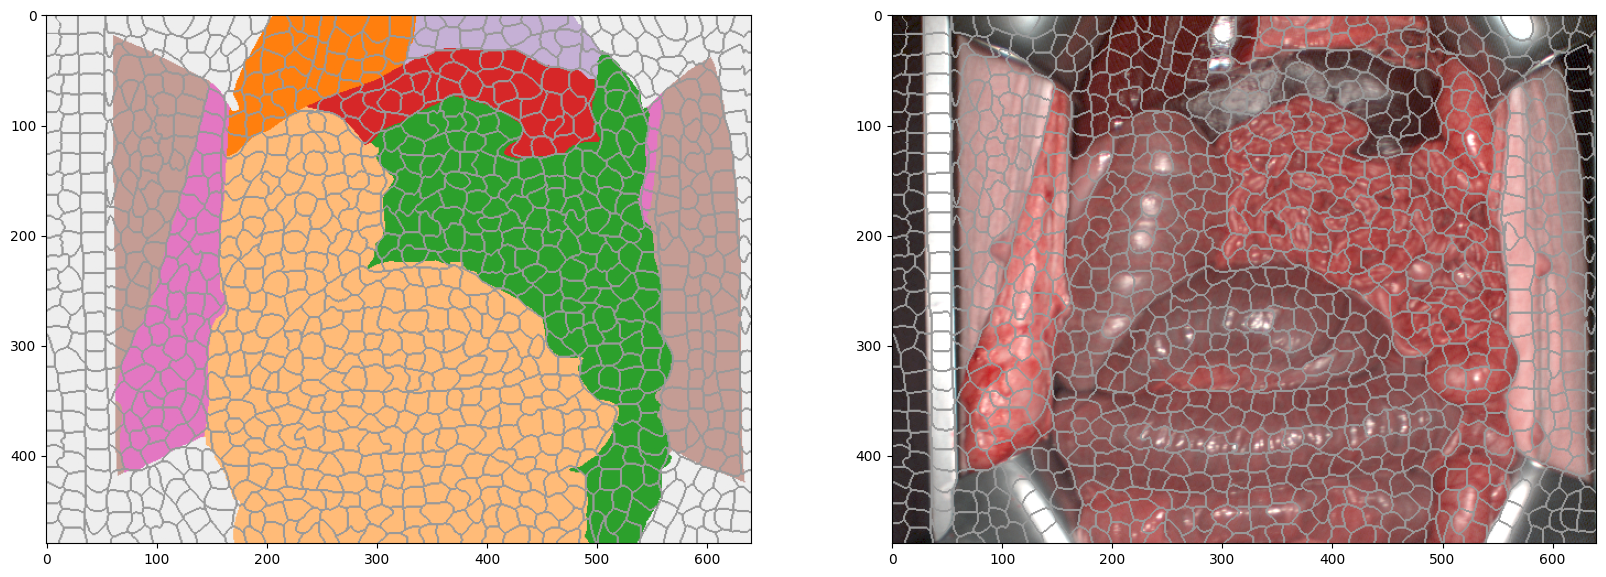

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(mark_boundaries(seg[:, :, :3], spxs, color=(0.6, 0.6, 0.6), mode="outer"))
ax2.imshow(mark_boundaries(rgb, spxs, color=(0.6, 0.6, 0.6), mode="inner"));